# Importing the modules


In [1]:
import os
import pandas as pd
import lyricsgenius as lg
import spotipy
import time
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

# Access Tokens

In [2]:
spotipy_client_id = 'c3e43077142f4e7bb70601747bd1f0d2'
spotipy_client_secret = '925f7025c8e6420f9be665401784c0f6'
spotipy_redirect_uri = 'https://google.com'
genius_access_token = 'jVHnDFkBvrvEsj_M8YUxbQ9t8mo2zIG19giBxlX_g7NeRz4W51gedM1YHTBX_U-4'

In [3]:
df = pd.read_excel('music.xlsx')

In [4]:
df['sentiment'].value_counts()

neg    50
pos    49
Name: sentiment, dtype: int64

In [5]:
df.head(3)

,Unnamed: 0,artists,track,mood,sentiment,lyrics
0,0,Usher,There Goes My Baby,relaxed,pos,There Goes My Baby Lyrics[Produced by Jim Jons...
1,1,Da'Ville,On My Mind,relaxed,pos,On My Mind LyricsAhhhhhhhh\nYou're om my mind\...
2,2,Rihanna,Rockstar 101,relaxed,pos,"ROCKSTAR 101 Lyrics[Intro]\nI told ya, I told ..."


In [6]:
df=df[['artists','track','sentiment']]

# Plotting

Text(0.5, 0, 'Sentiments')

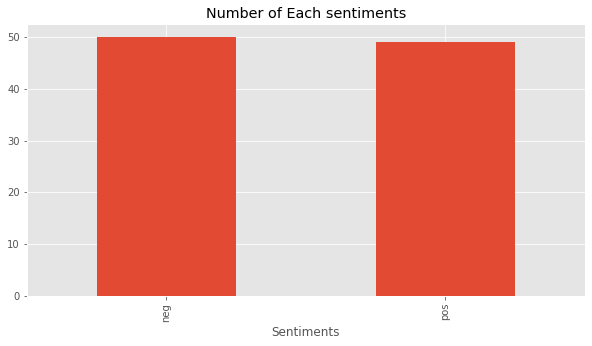

In [7]:
graph = df['sentiment'].value_counts().sort_index().plot(kind='bar',title='Number of Each sentiments',figsize=(10,5))
graph.set_xlabel('Sentiments')

# Genius API

In [8]:
genius = lg.Genius(genius_access_token)


In [11]:
l=[]
for i in range(len(df['track'])):
  song = genius.search_song(title=df['track'][i],artist=df['artists'][i])
  if song != None:
    lyrics = song.lyrics
    l.append(lyrics)
  else:
    l.append(None)

lyrics_df = pd.DataFrame()
lyrics_df['lyrics'] = l

Searching for "There Goes My Baby" by Usher...
Done.
Searching for "On My Mind" by Da'Ville...
Done.
Searching for "Rockstar 101 " by Rihanna...
Done.
Searching for "Bed" by J. Holiday...
Done.
Searching for "Don't Haffi Dread" by Morgan Heritage...
Done.
Searching for "My Love Is Your Love" by Whitney Houston...
Done.
Searching for "Study People" by Serani...
Done.
Searching for "Spellwork" by Austra...
Done.
Searching for "Can't Let You Go" by Coro...
Done.
Searching for "Slam" by Beenie Man...
Done.
Searching for "Love Him Like I Do " by Deitrick Haddon...
Done.
Searching for "ABC" by The Jackson 5...
Done.
Searching for "The Lady In My Life" by Maysa...
Done.
Searching for "We Got Love" by Ryan Shaw...
Done.
Searching for "I Love How You Love Me" by The Paris Sisters...
Done.
Searching for "I Came To Jesus" by New Direction...
Done.
Searching for "God Great God" by Kurt Carr & The Kurt Carr Singers...
Done.
Searching for "And I Love Her" by Kenny Lattimore...
Done.
Searching for "B

In [12]:
# join both data frames
df = pd.concat([df, lyrics_df], axis=1, join='inner')
df.head()

,artists,track,sentiment,lyrics
0,Usher,There Goes My Baby,pos,There Goes My Baby Lyrics[Produced by Jim Jons...
1,Da'Ville,On My Mind,pos,On My Mind LyricsAhhhhhhhh\nYou're om my mind\...
2,Rihanna,Rockstar 101,pos,"ROCKSTAR 101 Lyrics[Intro]\nI told ya, I told ..."
3,J. Holiday,Bed,pos,Bed Lyrics[Written by The-Dream and Los Da Mys...
4,Morgan Heritage,Don't Haffi Dread,neg,"Don’t Haffi Dread LyricsYeah, yeah, yeah - rag..."


In [13]:
# save data frame to excel
df.to_excel('music.xlsx')

# <b>Data Preprocessing</b>

### <b>1.Data Cleaning</b>

#### Checking for missing values


In [14]:
df.isna().sum()

artists      0
track        0
sentiment    0
lyrics       2
dtype: int64

In [15]:
df.dropna(how='any',inplace=True)

#### Checking for Duplicate values

In [16]:
df['track'].duplicated().sum()


0

In [17]:
df.drop_duplicates(subset='track',keep='last',inplace=True)


In [18]:
df['sentiment'].value_counts()

neg    49
pos    48
Name: sentiment, dtype: int64

### <b>2.Tokenization</b>

In [19]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91635\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
def preprocessText(text, remove_stops=False):
    
    # Remove everything between hard brackets
    text = re.sub(pattern="\[.+?\]( )?", repl='', string=text)

    # Change "walkin'" to "walking", for example
    text = re.sub(pattern="n\\\' ", repl='ng ', string=text)

    # Remove x4 and (x4), for example
    text = re.sub(pattern="(\()?x\d+(\))?", repl=' ', string=text)

    # Fix apostrophe issues
    text= re.sub(pattern="\\x91", repl="'", string=text)
    text = re.sub(pattern="\\x92", repl="'", string=text)
    text= re.sub(pattern="<u\+0092>", repl="'", string=text)
    
    # Make lowercase
    text = text.lower()

    # Remove \n from beginning
    text = re.sub(pattern='^\n', repl=' ', string=text)

    # Strip , ! ?, : and remaining \n from lyrics
    text = ''.join([char.strip(",!?:") for char in text])
    text = text.replace('\n', '  ')
    
    # Remove contractions
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"let\’s", "let us", text)
    text = re.sub(r"ain't", "aint", text)
    text = re.sub(r"ain\’t", "aint", text)
    text = re.sub(r"wanna", "want to", text)
    text = re.sub(r"gonna", "going to", text)
    text = re.sub(r"gotta", "go to", text)
    
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\â", "a", text)
    
    # Remove Symbols
    text = re.sub(r"[^\w\s]","", text)
    
    # remove single char
    text = re.sub(r"\b[a-zA-Z]\b","", text)
   
    #remove number
    text = re.sub(r"\d+", "", text)
    
    #remove duplicate char(oohhh,ohhhh,oohhhh,etc)
    text = re.sub(r"o+h", "oh", text)
    text = re.sub(r"oh+", "", text)
    
    # Remove remaining punctuation
    punc = string.punctuation
    text = ''.join([char for char in text if char not in punc])

    # Remove double spaces and beginning/trailing whitespace
    text = re.sub(pattern='( ){2,}', repl=' ', string=text)
    text = text.strip()
    
    return(text)

df['lyrics'] = df['lyrics'].apply(preprocessText)

### <b>3.Stopwords Removal</b>

In [21]:
import neattext.functions as nfx


In [22]:
df['lyrics'] = df['lyrics'].apply(nfx.remove_stopwords)

In [32]:
df.head(3)

,artists,track,sentiment,lyrics,lyrics_lemma
0,Usher,There Goes My Baby,pos,goes baby lyrics yeah right usher baby okay ye...,"[goe, babi, lyric, yeah, right, usher, babi, o..."
1,Da'Ville,On My Mind,pos,mind lyricsahhhhhhhh om mind yea verse thinkin...,"[mind, lyricsahhhhhhhh, om, mind, yea, vers, t..."
2,Rihanna,Rockstar 101,pos,rockstar lyrics told ya told ya told ya baby b...,"[rockstar, lyric, told, ya, told, ya, told, ya..."


# Vader Algorithm

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

sentiment_list = []
sentiment_score_list = []

for i in df['lyrics']:
    try:
        sentiment_score = analyser.polarity_scores(i)

        if sentiment_score['compound'] >= 0.2:
            sentiment_percentage = sentiment_score['compound']
            sentiment = 'Positive'
        elif sentiment_score['compound'] > -0.2 and sentiment_score['compound'] < 0.2:
            sentiment_percentage = sentiment_score['compound']
            sentiment = 'Neutral'
        elif sentiment_score['compound'] <= -0.2:
            sentiment_percentage = sentiment_score['compound']
            sentiment = 'Negative'

        sentiment_list.append(sentiment)
        sentiment_score_list.append((abs(sentiment_percentage) * 100))
        
    except:
        sentiment_list.append('None')
        sentiment_score_list.append(0)

df['vader_sentiment'] = sentiment_list


In [46]:
df.vader_sentiment.value_counts()

Positive    58
Negative    36
Neutral      3
Name: vader_sentiment, dtype: int64

In [47]:
df.head(3)

,artists,track,sentiment,lyrics,lyrics_lemma,vader_sentiment,vader_sentiment_2
0,Usher,There Goes My Baby,1,goes baby lyrics yeah right usher baby okay ye...,goe babi lyric yeah right usher babi okay yeah...,Positive,Positive
1,Da'Ville,On My Mind,1,mind lyricsahhhhhhhh om mind yea verse thinkin...,mind lyricsahhhhhhhh om mind yea vers thinkin ...,Positive,Positive
2,Rihanna,Rockstar 101,1,rockstar lyrics told ya told ya told ya baby b...,rockstar lyric told ya told ya told ya babi ba...,Positive,Positive


### label encoding

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [50]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])  # 1->positive 0->negative

C:\Users\91635\AppData\Local\Temp/ipykernel_31584/563678025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = le.fit_transform(df['sentiment'])  # 1->positive 0->negative


In [51]:
df.head(3)

,artists,track,sentiment,lyrics,lyrics_lemma,vader_sentiment
0,Usher,There Goes My Baby,1,goes baby lyrics yeah right usher baby okay ye...,goe babi lyric yeah right usher babi okay yeah...,Positive
1,Da'Ville,On My Mind,1,mind lyricsahhhhhhhh om mind yea verse thinkin...,mind lyricsahhhhhhhh om mind yea vers thinkin ...,Positive
2,Rihanna,Rockstar 101,1,rockstar lyrics told ya told ya told ya baby b...,rockstar lyric told ya told ya told ya babi ba...,Positive


In [90]:
corpus = []
for sentence in df['lyrics']:
    corpus.append(sentence)

### countvecterizer

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, -4].values

### radomising rows

In [105]:
df = df.sample(frac=1).reset_index(drop=True)

# <b>Training Models</b>

In [142]:
# gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
# ada boost classifier
from sklearn.ensemble import AdaBoostClassifier
# K nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
# train test split
from sklearn.model_selection import train_test_split
# confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
# other metrics
from sklearn.metrics import f1_score, precision_score, recall_score


In [143]:
# splitting the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 1. GaussianNB

In [144]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
y_pred = gnb_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")  
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))

Accuracy Score : 90.0 %
F-1 Score :  0.9166666666666666
Precision Score :  0.9166666666666666
Recall Score :  0.9166666666666666


# 2. AdaBoost

In [145]:
ada_model = AdaBoostClassifier(random_state=123)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))

Accuracy Score : 65.0 %
F-1 Score :  0.6666666666666666
Precision Score :  0.7777777777777778
Recall Score :  0.5833333333333334


# 3. K-Nearest Neighbor

In [146]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))

Accuracy Score : 50.0 %
F-1 Score :  0.2857142857142857
Precision Score :  1.0
Recall Score :  0.16666666666666666


# Saving model

In [147]:
import joblib

In [151]:
joblib.dump(knn_model,'knn_model')
joblib.dump(gnb_model,'gnb_model')
joblib.dump(ada_model,'ada_model')


['ada_model']